In [1]:
import os
import sys
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.prompts import PromptTemplate

from langchain_core.retrievers import BaseRetriever
from typing import Dict, Any
from langchain.docstore.document import Document
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate

In [2]:
import os
from config import HF_TOKEN, open_ai_key
import warnings
from langchain.embeddings import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain_huggingface  import HuggingFaceEmbeddings
from langchain_ollama import ChatOllama

# Ignore all the warnings given by different packages
warnings.filterwarnings('ignore')

# Retrieve the open ai and hf tokens from the configuration file
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HF_TOKEN
os.environ["OPENAI_API_KEY"] = open_ai_key

# Select the GPU as the device
model_kwargs = {'device': 'cuda'}

# Required for fast similarity computations
encode_kwargs = {'normalize_embeddings': True}

# Initialize Embeddings, GPT and Ollama Model
llm_gpt = ChatOpenAI(model_name="gpt-4o-mini", openai_api_key=open_ai_key)

llm_text = ChatOllama(
    model="llama3.2:1b",
    temperature=0.5,
    num_thread = 2,
    format = ''
)

llm_json = ChatOllama(
    model="llama3.2:1b",
    temperature=0.5,
    num_thread = 2,
    format = 'json'
)

model_embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

In [5]:
from utils1 import *

all_experiments = [
"recursive_4096",
"recursive_2048",
"recursive_512",
"recursive_256",
"recursive_1024",
"fixed",
"semantic",
"page",
"agentic",
"agentic_custom",
"semantic_percentile",
"semantic_iq",
"semantic_sd",
"semantic_gradient"]

all_vector_dbs = {}
# results = {}

for e in all_experiments:
    all_vector_dbs[e] = create_or_load_vector_db(chunked_documents="", persist_directory=f"./vector_store_{e}", load=True)

In [13]:
from langchain_community.document_loaders import PyMuPDFLoader
import os

pdf_folder_path = "./utils/data"
documents = []
for file in os.listdir(pdf_folder_path):
    if file.endswith('.pdf'):
        pdf_path = os.path.join(pdf_folder_path, file)
        loader = PyMuPDFLoader(pdf_path)
        documents.extend(loader.load())
        
print(f"total documents loaded - {len(documents)}")

total documents loaded - 427


In [14]:
from langchain_experimental.text_splitter import SemanticChunker

text_splitter = SemanticChunker(model_embeddings)
chunked_documents_semantic  = text_splitter.split_documents(documents)

In [17]:
import copy

chunks = copy.deepcopy(chunked_documents_semantic)

for d in chunks:
    d.metadata = d.metadata | {"index": len(d.page_content)}

In [25]:
len(chunks)

1049

In [21]:
vectordb_semantic = create_or_load_vector_db(chunked_documents=chunks, persist_directory="./vector_store_context_window_semantic", load=False)

1049

In [29]:
def get_chunk_by_index(vectorstore, target_index: int) -> Document:
    all_docs = vectorstore.similarity_search("", k=len(vectorstore.get()['documents']))
    for doc in all_docs:
        if doc.metadata.get('index') == target_index:
            return doc
    return None

In [37]:
chunk = get_chunk_by_index(vectordb_semantic, 300)
print(chunk.page_content)

Power to remove difficulties 
[Repealed by the Act No. 44 of 1966, w.e.f. 17th., June, 1967.]  
73-I. Duration of Chapter VA 
The Central Government may, by [notification in the Official Gazette, (vide SO No. 173(E) dated 26th., March, 1973)] direct that the provisions of this Chapter shall cease to


In [39]:
from typing import List
def retrieve_with_context_overlap(vectorstore, retriever, query: str, num_neighbors: int = 1, chunk_size: int = 200, chunk_overlap: int = 20) -> List[str]:
    """
    Retrieve chunks based on a query, then fetch neighboring chunks and concatenate them, 
    accounting for overlap and correct indexing.

    Args:
    vectorstore (VectorStore): The vectorstore containing the chunks.
    retriever: The retriever object to get relevant documents.
    query (str): The query to search for relevant chunks.
    num_neighbors (int): The number of chunks to retrieve before and after each relevant chunk.
    chunk_size (int): The size of each chunk when originally split.
    chunk_overlap (int): The overlap between chunks when originally split.

    Returns:
    List[str]: List of concatenated chunk sequences, each centered on a relevant chunk.
    """
    relevant_chunks = retriever.get_relevant_documents(query)
    result_sequences = []

    for chunk in relevant_chunks:
        current_index = chunk.metadata.get('index')
        if current_index is None:
            continue

        # Determine the range of chunks to retrieve
        start_index = max(0, current_index - num_neighbors)
        end_index = current_index + num_neighbors + 1  # +1 because range is exclusive at the end

        # Retrieve all chunks in the range
        neighbor_chunks = []
        for i in range(start_index, end_index):
            neighbor_chunk = get_chunk_by_index(vectorstore, i)
            if neighbor_chunk:
                neighbor_chunks.append(neighbor_chunk)

        # Sort chunks by their index to ensure correct order
        neighbor_chunks.sort(key=lambda x: x.metadata.get('index', 0))

        # Concatenate chunks, accounting for overlap
        concatenated_text = neighbor_chunks[0].page_content
        for i in range(1, len(neighbor_chunks)):
            current_chunk = neighbor_chunks[i].page_content
            overlap_start = max(0, len(concatenated_text) - chunk_overlap)
            concatenated_text = concatenated_text[:overlap_start] + current_chunk

        result_sequences.append(concatenated_text)

    return result_sequences

In [40]:
chunks_query_retriever = vectordb_semantic.as_retriever(search_kwargs={"k": 1})

In [41]:
import time
import json

with open("test_data_30.json", "r") as file:
    cleaned_data = json.load(file)

In [43]:
query = cleaned_data["question_1"]["question"]

In [46]:
baseline_chunk = chunks_query_retriever.get_relevant_documents(query
    ,
    k=1
)

In [47]:
baseline_chunk

[Document(id='e8b011f7-7aff-4ad0-8f1f-c62e505ab29c', metadata={'author': 'Naseem', 'creationDate': "D:20180712102627+05'30'", 'creationdate': '2018-07-12T10:26:27+05:30', 'creator': 'Microsoft® Word 2010', 'file_path': './utils/data/act_14.pdf', 'format': 'PDF 1.5', 'index': 2437, 'keywords': '', 'modDate': "D:20180712102627+05'30'", 'moddate': '2018-07-12T10:26:27+05:30', 'page': 1, 'producer': 'Microsoft® Word 2010', 'source': './utils/data/act_14.pdf', 'subject': '', 'title': '', 'total_pages': 5, 'trapped': ''}, page_content='2 \nTHE EMPLOYMENT EXCHANGES (COMPULSORY NOTIFICATION OF VACANCIES) \nACT, 1959 \nACT NO. 31 OF 1959 \n[2nd September, 1959.] \nAn Act to provide for the compulsory notification of vacancies to employment exchanges. BE it enacted by Parliament in the Tenth Year of the Republic of India as follows:— \n 1. Short title, extent and commencement.—(1) This Act may be called the Employment Exchanges \n(Compulsory Notification of Vacancies) Act, 1959. (2) It extends t

In [68]:
enriched_chunks = retrieve_with_context_overlap(
    vectordb_semantic,
    chunks_query_retriever,
    query,
    num_neighbors=1,
    chunk_size=400,
    chunk_overlap=200
)

In [69]:
enriched_chunks

['2 \nTHE EMPLOYMENT EXCHANGES (COMPULSORY NOTIFICATION OF VACANCIES) \nACT, 1959 \nACT NO. 31 OF 1959 \n[2nd September, 1959.] \nAn Act to provide for the compulsory notification of vacancies to employment exchanges. BE it enacted by Parliament in the Tenth Year of the Republic of India as follows:— \n 1. Short title, extent and commencement.—(1) This Act may be called the Employment Exchanges \n(Compulsory Notification of Vacancies) Act, 1959. (2) It extends to the whole of India1* * *. (3) It shall come into force in a State on such date2as the Central Government may, by notification in \nthe Official Gazette, appoint in this behalf for such State and different dates may be appointed for \ndifferent States or for different areas of a State. 2. Definitions.—In this Act, unless the context otherwise requires,— \n(a)“appropriate Government” means— \n(1) in relation to— \n(a) any establishment of any railway, major port, mine or oil-field, or \n(b) any establishment owned, controlled or

In [71]:
class AnswerStructure(BaseModel):
    answer: str = Field(description="answer to the given question")

parser = JsonOutputParser(pydantic_object=AnswerStructure)

import time
def get_llm_response(query, vectordb, retriever):
    # pull the prompt from HF hub
    prompt = """
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. \
    If you don't know the answer, just say that you don't know. Give a detailed answer to the question by reading the context
    \nQuestion: {question} \nContext: {context}
    Give answer in the below json format only. No deviations:
    {{
        "answer":str
    }}
    Your response must be strictly valid JSON with no additional text, markdown formatting, or commentary.
    Make sure to have the key with the name "answer"
    don't include any backticks like ``` or any text like ```json while starting the json
"""

    SYSTEM_PROMPT = PromptTemplate(
    input_variables=["context", "question"], template=prompt
)

    # create a chain with prompt and llama 3.2 1B llm
    rag_chain_from_docs = (
            RunnablePassthrough()
            | SYSTEM_PROMPT
            | llm_json
            | parser
        )

    docs_content = retrieve_with_context_overlap(
            vectordb,
            retriever,
            query,
            num_neighbors=1,
            chunk_size=400,
            chunk_overlap=200
        )


    try:
        result = rag_chain_from_docs.invoke({"question": query, "context": docs_content})
    except Exception as e:
        print(str(e))
        time.sleep(5)
        result = rag_chain_from_docs.invoke({"question": query, "context": docs_content})
    
    return result["answer"], docs_content

In [72]:
import concurrent.futures
import tqdm

def process_llm_response(k, v, vectordb, retriever):
    """Function to fetch LLM response in parallel."""
    answer, context = get_llm_response(v["question"], vectordb, retriever)
    return k, {"question": v["question"], "answer": answer, "context":context}

def get_response(cleaned_data, vectordb, retriever):
    llm_response_data = {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
        futures = {executor.submit(process_llm_response, k, v, vectordb, retriever): k for k, v in cleaned_data.items()}
        
        for future in tqdm.tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            k, result = future.result()
            llm_response_data[k] = result
        return llm_response_data

In [73]:
import pandas as pd
from ragas import SingleTurnSample, EvaluationDataset
from ragas import evaluate
from ragas.run_config import RunConfig
import warnings
import random
import time

from ragas.metrics import LLMContextPrecisionWithReference, LLMContextRecall, ResponseRelevancy, Faithfulness

warnings.filterwarnings('ignore')
        
def save_evaluator_results(result, name):
    result.to_csv(f"evaluation_{name}.csv")

def evaluator(name, cleaned_data, vectordb, retriever):
    data_list = []
    
    # Get Response from the selected Vector DB
    llm_response_data = get_response(cleaned_data, vectordb, retriever)

    # Persist the response for later usage
    with open(f"llm_response_data_{name}.json", "w") as file:
        json.dump(llm_response_data, file, indent=4)

    # Create an evaluation dataset
    for k, v in llm_response_data.items():
        row = SingleTurnSample(
            user_input=v["question"],
            retrieved_contexts=v["context"],
            response=v["answer"],
            reference=cleaned_data[k]["answer"],
            reference_contexts = [cleaned_data[k]["answer"]]
        )
    
        data_list.append(row)
    dataset = EvaluationDataset(samples=data_list)
    

    # To make the evaluation faster, we will go with two metrics at a time
    result_1 = evaluate(dataset, llm=llm_gpt, embeddings=model_embeddings, run_config=RunConfig(max_workers=10, max_retries=20, timeout=180), 
                      metrics=[LLMContextPrecisionWithReference(), LLMContextRecall()]).to_pandas()

    # Adding a sleep timer to avoid rate limit or token limit error
    time.sleep(30)
    
    result_2 = evaluate(dataset, llm=llm_gpt, embeddings=model_embeddings, run_config=RunConfig(max_workers=10, max_retries=20, timeout=180), 
                      metrics=[ResponseRelevancy(), Faithfulness()]).to_pandas()

    # Merge all the metrics
    result = pd.merge(result_1, result_2[['user_input', 'answer_relevancy', 'faithfulness']], on='user_input')

    # Persist the metrics result for the experiment
    save_evaluator_results(result, name)
    
    return result

In [74]:
all_experiments = [
"recursive_4096",
"recursive_2048",
"recursive_512",
"recursive_256",
"recursive_1024",
"fixed",
"semantic",
"page",
"agentic",
"agentic_custom",
"semantic_percentile",
"semantic_iq",
"semantic_sd",
"semantic_gradient"]

all_vector_dbs = {}
results = {}

for e in all_experiments:
    all_vector_dbs[e] = create_or_load_vector_db(chunked_documents="", persist_directory=f"./vector_store_{e}", load=True)

In [76]:
result = evaluator("cw_"+experiment_name, cleaned_data, vectordb_semantic, vectordb_semantic.as_retriever(search_kwargs={"k": 1}))

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:23<00:00,  2.56it/s]


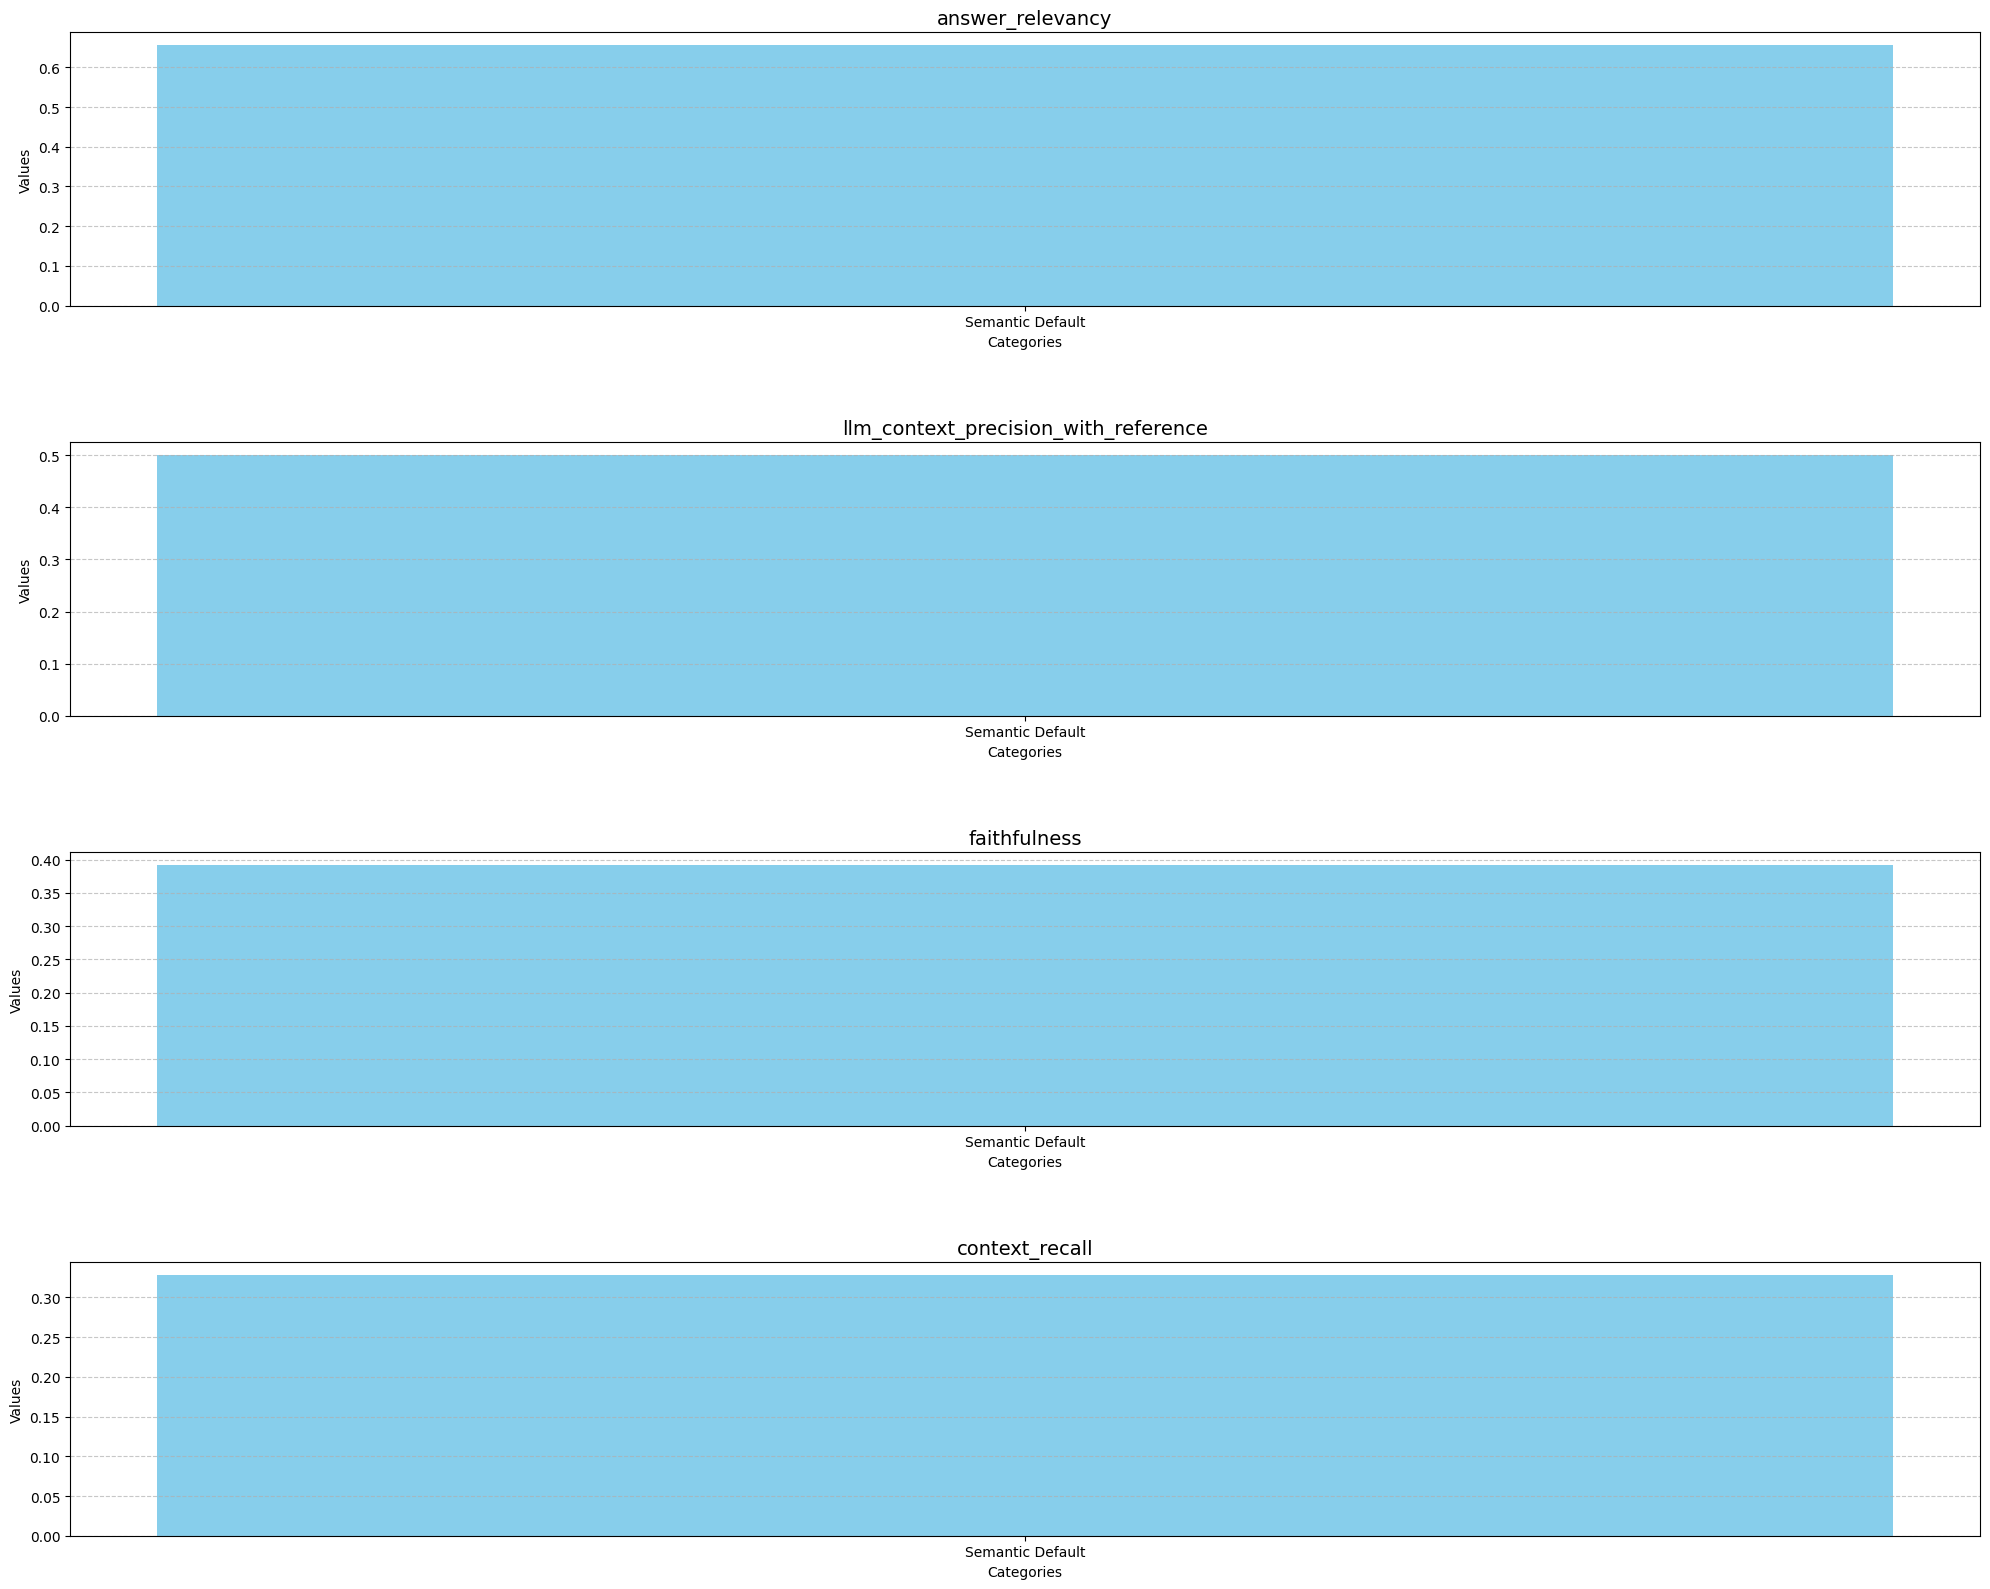

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
# categories = ['Fixed', 'Recursive', 'Semantic', 'Agentic', "Page"]

categories = ["Semantic Default"]


metrics = ["answer_relevancy", "llm_context_precision_with_reference", "faithfulness", "context_recall"]

values = []
for m in metrics:
    values.append([
    np.mean(np.nan_to_num(result[m], nan=0)),
])

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(4,1, figsize=(20, 16))

# Titles for each subplot
titles = ['Plot 1', 'Plot 2', 'Plot 3', 'Plot 4']

# Iterate over each subplot and create a bar plot
for i, ax in enumerate(axs.flat):
    ax.bar(categories, values[i], color='skyblue')
    ax.set_title(metrics[i], fontsize=14)
    ax.set_xlabel('Categories', fontsize=10)
    ax.set_ylabel('Values', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap and add space between plots
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

# Show the plots
plt.show()